In [1]:
import sys
sys.path.append('../')


In [2]:
import numpy as np
from src.fingerspell.ui.common import draw_text

# Test if draw_text works
test_img = np.zeros((200, 400, 3), dtype=np.uint8)
result = draw_text(test_img, "Test ☑☐ ÆØÅ", (20, 100), font_size=32)

import cv2
cv2.imshow('Test', result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [1]:
import sys
sys.path.append('../')

import cv2
import numpy as np

# Test 1: draw_instructions
from src.fingerspell.ui.common import draw_instructions

test_img = np.zeros((720, 1280, 3), dtype=np.uint8)
test_img = draw_instructions(test_img, is_paused=False, position='topright')

cv2.imshow('Test Instructions', test_img)
cv2.waitKey(0)

# Test 2: draw_letter_status
from src.fingerspell.collection.data_management import draw_letter_status

test_img2 = np.zeros((720, 1280, 3), dtype=np.uint8)
alphabet = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
collected = {l: 0 for l in alphabet}
targets = {l: 2500 for l in alphabet}
dynamic = {'H', 'J', 'U', 'X', 'Z'}


test_img2 = draw_letter_status(test_img2, alphabet, collected, targets, dynamic)

cv2.imshow('Test Letter Status', test_img2)
cv2.waitKey(0)


cv2.destroyAllWindows()

box HxW: 160x244


In [7]:
t = 'a\nb\nC'
if not isinstance(t, list):
    x = t.split('\n')

print(x)

['a', 'b', 'C']


In [3]:
import matplotlib.pyplot as plt
import cv2
import textwrap
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path

from src.fingerspell.ui.common import draw_text, draw_instructions

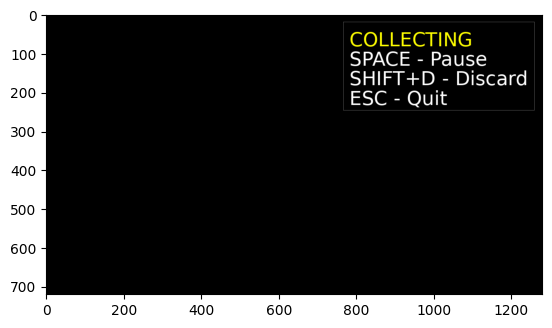

In [4]:
test_img = np.zeros((720, 1280, 3), dtype=np.uint8)

instructions = [
    "COLLECTING",
    "SPACE - Pause",
    "SHIFT+D - Discard",
    "ESC - Quit"
]

test_img = draw_instructions(test_img, False)
plt.imshow(test_img)

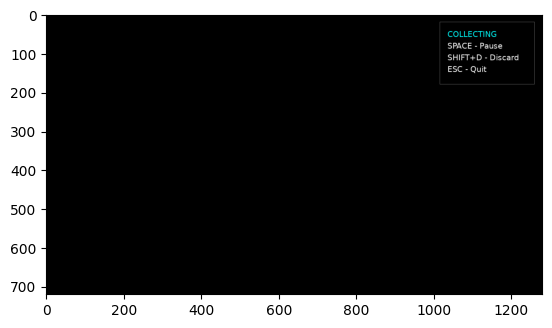

In [12]:
plt.imshow(test_img)